In [8]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch

In [9]:
# Order and names in the pseudocode
# x=(22.5,0) y=(0,-45) z=(0,0) a=(45,0)
# Channels: 1 2 3 4 13 14 23 24

## Matching the datafile name with the respective input and measurement basis
MBasisList=['x','y','z'] #in order: D L H

BasesO=['DD','DL','DH','LD','LL','LH', 'HD','HL', 'HH']

In [10]:
def FindingFile(containing, filenames):
    for file in filenames:
         if fnmatch.fnmatch(file, 'Bigiteration_0_'+containing+'_*'):
            return file
    print('No file containing: Bigiteration_0_', containing, '...')
    pass

In [11]:
### Getting the number of necessary files
n_files=0
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        n_files+=1
        print

In [13]:
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)

mbasis_number=6

qubit_number=2
numberofchannels=8

dirinv=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype=complex)

Pauli=np.asarray([
        [[1,0],
        [0,1]],


        [[0,1],
        [1,0]],


        [[0,-1j],
        [1j,0]],


        [[1,0],
        [0,-1]]])

tomo_n=0
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    #filenames_aux=filenames_aux[1:]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        print(index, filenames_aux_second)
        os.chdir(working_dir+'\\'+filename+'\\'+filenames_aux_second+'\\'+'StateTomo')
        datafiles=[i for i in glob.glob("*")]
        
        counts=np.zeros((numberofchannels,3**qubit_number), dtype=int)
        counts_aux=np.zeros((2**qubit_number,3**qubit_number), dtype=float)
        heralding_single=np.zeros((3**qubit_number), dtype=int)
        xp_counts=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
        efficiencies=np.zeros(8, dtype=float)
        expectations=np.zeros(3, dtype=float)

        ##################### STATE TOMOGRAPHY ##############################

        ##Calculating the efficiencies of each detector
        eff=np.array(['zz', 'za', 'az', 'aa'])
        for w in range(4):
            file=FindingFile(eff[w], datafiles)
            with open(file) as file: 
                for line in file:
                    fields = line.split()
                    #for iter, field in enumerate(fields[4:8]):
                    for iter in range (len(fields)-7):
                        efficiencies[iter]+=float(fields[iter])
            #print('Base, counts', w, fields)


        ### Simulated counts using Simon's tomography functions
        # data is saved as "Bigiteration_0_xy" with x(y) being the measurement(input) basis
        # H is channels 2 and 3
        bases=np.array(['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'])#, ## order: D, L, H



        ### Opening the data files and writing the data in counts_aux array
        for w in range(3**qubit_number):
            file=FindingFile(bases[w], datafiles)
            with open(file) as file: 
                for line in file:
                    fields = line.split()
                    for iter in range (len(fields)-7):
                        # In counts[a][b][c][d], 'a' corresponds to the channel (in order): 1 2 3 4 13 14 23 24 (defined in pseudo)
                        counts[iter][w]=fields[iter]

            counts_aux[0][w]=counts[-2][w]
            counts_aux[1][w]=counts[-1][w]
            counts_aux[2][w]=counts[-4][w]
            counts_aux[3][w]=counts[-3][w]
            #heralding_single[w]=counts[3][w]

        ### Normalizing the counts with the detectors efficiencies
        efficiencies=efficiencies[4:8]/np.max(efficiencies[4:8])
        aux=0
        for w in range(3**qubit_number):
           #heralding_single[w]=heralding_single[w]/efficiencies[3]
            counts_aux[0][w]=counts_aux[0][w]/float(efficiencies[2])#*heralding_single[w]*1e-6)
            counts_aux[1][w]=counts_aux[1][w]/float(efficiencies[3])#*heralding_single[w]*1e-6)
            counts_aux[2][w]=counts_aux[2][w]/float(efficiencies[0])#*heralding_single[w]*1e-6)
            counts_aux[3][w]=counts_aux[3][w]/float(efficiencies[1])#*heralding_single[w]*1e-6)
            
            #print('w, Counts: ', w, counts_aux[0][w])

            #if w==0: ## XX expectation value
            #    expectations[0]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            #if w==4: ## YY expectation value
            #    expectations[1]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            #if w==8: ## ZZ expectation value
            #    expectations[2]=(counts_aux[1][w]+counts_aux[2][w]-counts_aux[0][w]-counts_aux[3][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            if (aux<(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])):
                aux=(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        ### Sanity check: This prints the normalized number of counts for each measurement basis
        # The total number of counts (considering all output ports of the PBS's) should remain constant (we should see 1 for all of them)
        for w in range(3**qubit_number):
            print('Output basis: ', BasesO[w], '; Sum of counts normalized: ', (counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])/aux)

        xp_counts[:][:]=np.array(np.transpose(counts_aux[:][:])) # get the experimental counts

        statetomo=LRETomography(int(qubit_number), xp_counts[:][:], 'C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies')
        statetomo.run(correct_eff=None) ### Runs fast maximum likelihood estimation
        dirinv[tomo_n]=statetomo.quantum_state.get_density_matrix()
        print('\n Fast maximum likelihood estimation: \n', dirinv[tomo_n], '\n')
        tomo_n+=1

0 StateTomography202205241431
Output basis:  DD ; Sum of counts normalized:  1.0
Output basis:  DL ; Sum of counts normalized:  0.9941471239083554
Output basis:  DH ; Sum of counts normalized:  0.9951254310972806
Output basis:  LD ; Sum of counts normalized:  0.9927190907986649
Output basis:  LL ; Sum of counts normalized:  0.9944295764684561
Output basis:  LH ; Sum of counts normalized:  0.9932491169381302
Output basis:  HD ; Sum of counts normalized:  0.9942067307710705
Output basis:  HL ; Sum of counts normalized:  0.99415107426836
Output basis:  HH ; Sum of counts normalized:  0.9997745249547485

 Fast maximum likelihood estimation: 
 [[ 1.67744046e-03+5.14125051e-19j -3.19175496e-03+3.85565181e-03j
   2.84530774e-03-1.54189807e-03j -1.10359875e-05+7.27389251e-04j]
 [-3.19175496e-03-3.85565181e-03j  5.01967965e-01-2.44879207e-19j
  -4.95047782e-01+3.44449026e-03j  5.67884296e-05-2.07955184e-03j]
 [ 2.84530774e-03+1.54189807e-03j -4.95047782e-01-3.44449026e-03j
   4.94426776e-01-2.4

Output basis:  DD ; Sum of counts normalized:  0.997102581031302
Output basis:  DL ; Sum of counts normalized:  0.9948292991380286
Output basis:  DH ; Sum of counts normalized:  0.9956388718049801
Output basis:  LD ; Sum of counts normalized:  0.9985121947706863
Output basis:  LL ; Sum of counts normalized:  1.0
Output basis:  LH ; Sum of counts normalized:  0.9973630821267205
Output basis:  HD ; Sum of counts normalized:  0.9983331203288319
Output basis:  HL ; Sum of counts normalized:  0.9955469692171526
Output basis:  HH ; Sum of counts normalized:  0.998137127802271

 Fast maximum likelihood estimation: 
 [[ 2.08422189e-03-4.68834101e-19j  6.03307450e-03+6.89038091e-04j
   5.68082320e-03-1.12850862e-03j -1.16420031e-04-9.97434918e-04j]
 [ 6.03307450e-03-6.89038091e-04j  4.97590437e-01+5.70400852e-17j
   4.94571719e-01-3.96962165e-03j -5.22033669e-03+9.16664969e-04j]
 [ 5.68082320e-03+1.12850862e-03j  4.94571719e-01+3.96962165e-03j
   4.98350409e-01-5.74546279e-17j -5.44259130e-03-1


 Fast maximum likelihood estimation: 
 [[ 0.48535335-5.42173016e-17j  0.0940389 -1.75951706e-03j
  -0.04194596+7.81183114e-02j  0.24051126-4.13950537e-01j]
 [ 0.0940389 +1.75951706e-03j  0.0202882 +1.31943642e-17j
  -0.00622643+1.39089052e-02j  0.04700299-8.12784725e-02j]
 [-0.04194596-7.81183114e-02j -0.00622643-1.39089052e-02j
   0.01934665+1.68046587e-18j -0.08762837-5.26468215e-03j]
 [ 0.24051126+4.13950537e-01j  0.04700299+8.12784725e-02j
  -0.08762837+5.26468215e-03j  0.4750118 +3.93424715e-17j]] 

8 StateTomography202205271336AfterChannel
Output basis:  DD ; Sum of counts normalized:  0.9981719897016961
Output basis:  DL ; Sum of counts normalized:  0.9904528215683036
Output basis:  DH ; Sum of counts normalized:  0.9942778286088141
Output basis:  LD ; Sum of counts normalized:  0.9995949756370675
Output basis:  LL ; Sum of counts normalized:  0.9999050689932754
Output basis:  LH ; Sum of counts normalized:  1.0
Output basis:  HD ; Sum of counts normalized:  0.9957223620452318


Output basis:  DD ; Sum of counts normalized:  1.0
Output basis:  DL ; Sum of counts normalized:  0.9923144194855432
Output basis:  DH ; Sum of counts normalized:  0.9923790593372133
Output basis:  LD ; Sum of counts normalized:  0.9868869825630006
Output basis:  LL ; Sum of counts normalized:  0.9904041529621912
Output basis:  LH ; Sum of counts normalized:  0.9875867167447089
Output basis:  HD ; Sum of counts normalized:  0.9877649701717843
Output basis:  HL ; Sum of counts normalized:  0.9879106027851985
Output basis:  HH ; Sum of counts normalized:  0.9961714495692727

 Fast maximum likelihood estimation: 
 [[ 0.48762867+4.09725398e-17j -0.01551144-6.01809405e-02j
   0.04725895-3.74407632e-02j  0.41386251+2.45659719e-01j]
 [-0.01551144+6.01809405e-02j  0.01343648-1.54936550e-18j
   0.0019267 +1.21784118e-02j -0.04661365+3.59806793e-02j]
 [ 0.04725895+3.74407632e-02j  0.0019267 -1.21784118e-02j
   0.01252964-7.15795844e-19j  0.01511805+6.00829618e-02j]
 [ 0.41386251-2.45659719e-01j 

In [14]:
### Fidelity with expectation values
print("Fidelity is: ", (1+np.sum(np.abs(expectations)))/4)

Fidelity is:  0.25


In [15]:
### Functions that will be necessary
def fidelity(ideal, real):
    return (ideal@real@np.transpose(np.conjugate(ideal)))

def GeneralUnitary(x):
    return np.array([[np.exp(1j*x[0])*np.cos(x[2]), np.exp(1j*x[1])*np.sin(x[2])],[-np.exp(-1j*x[1])*np.sin(x[2]), np.exp(-1j*x[0])*np.cos(x[2])]])

def ApplyUnitaryToDM(U, dm):
    return U@dm@np.transpose(np.conjugate(U))

def fUnitary(x, *args):
    U1=GeneralUnitary(x[:3])
    U2=GeneralUnitary(x[3:])
    return -np.abs(fidelity(bell, ApplyUnitaryToDM(np.kron(U1,U2), dirinv[index])))

### Jones formalism representation of a waveplate as a funtion of:
### angle of the WP to the horizontal (t) and the phase difference induced between V and H (n)
def WP_rotation(t, n):
    R= np.exp(-1j*n/2)*np.array([[np.cos(t)**2+np.exp(1j*n)*np.sin(t)**2,(1-np.exp(1j*n))*np.cos(t)*np.sin(t)],
                [(1-np.exp(1j*n))*np.cos(t)*np.sin(t),np.sin(t)**2+np.exp(1j*n)*np.cos(t)**2]])
    return(R)

In [16]:
### Fidelity as a projection

#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

for i in range(n_files):
    print(fidelity(bell, dirinv[i]))

(0.0031495889996556352+2.168404344971009e-19j)
(0.9906966755602378-8.673617379884035e-19j)
(0.04506878630928873+2.7755575615628914e-17j)
(0.9908304370522425+2.862293735361732e-17j)
(0.02349859203625887-2.949029909160572e-17j)
(0.0027220521211596665+3.2526065174565133e-19j)
(0.0033377346163210495-2.168404344971009e-19j)
(0.9925421419327733+3.469446951953614e-18j)
(0.0029048849668170482+1.0842021724855044e-19j)
(0.0038392384684747594-1.4094628242311558e-18j)
(0.9921679340253766+1.3227266504323154e-17j)
(0.0076241730890050695+1.431146867680866e-17j)
(0.9914088123745082+0j)
(0.9922610063972814-8.673617379884035e-19j)
(0.007236615381457376-1.951563910473908e-18j)
(0.013590997129860396-5.204170427930421e-18j)
(0.9914562101236657-2.7755575615628914e-17j)
(0.0155155630034248+6.071532165918825e-18j)
(0.9922076128337314+1.3877787807814457e-17j)
(0.9921118002370175+1.734723475976807e-18j)
(0.041419202506773334+1.214306433183765e-17j)
(0.991613669747736+1.235990476633475e-17j)
(0.00628117407944850

In [17]:
### Optimization of a unitary up to isometry
fid=np.zeros((n_files))
Optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number))
for index in range(n_files):
    result_w=diffev2(fUnitary, x0=np.array([0, 0.4, 0, 0, 0.3, 1.5]), args=dirinv[index], strategy=Best1Bin, bounds=[(-np.pi,np.pi)]*6, npop=50, gtol=100, disp=True, ftol=1e-20, itermon=VerboseMonitor(50), handler=False)
    print('\n The parameters are: ', index, result_w)

    print('\n with a fidelity of: ', -fUnitary(result_w, bellmatrix))

    Unit1=GeneralUnitary(result_w[:3])
    Unit2=GeneralUnitary(result_w[3:])
    print('Unitaries: \n U1=', Unit1, '\n U2=', Unit2)
    Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv[index])
    print('\n State after unitaries: \n', Optimized_matrix[index])
    fid[index]=fidelity(bell, Optimized_matrix[index])
    print("\n\n Fidelity is: ", fidelity(bell, Optimized_matrix[index]))

Generation 0 has ChiSquare: -0.001488
Generation 50 has ChiSquare: -0.993267
Generation 100 has ChiSquare: -0.993267
Generation 150 has ChiSquare: -0.993267
Generation 200 has ChiSquare: -0.993267
Generation 250 has ChiSquare: -0.993267
Generation 300 has ChiSquare: -0.993267
Generation 350 has ChiSquare: -0.993267


C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_18372/2094743015.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv[index])


STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.993267
         Iterations: 363
         Function evaluations: 18200

 The parameters are:  0 [-9.62626369e-01 -1.44232389e+00 -3.01364283e-03 -2.53689540e+00
 -2.75371611e-01 -2.19259856e-04]

 with a fidelity of:  0.9932673967744535
Unitaries: 
 U1= [[ 5.71363916e-01-0.82069129j -3.86105280e-04+0.0029888j ]
 [ 3.86105280e-04+0.0029888j   5.71363916e-01+0.82069129j]] 
 U2= [[-8.22674230e-01-5.68513028e-01j -2.10999069e-04+5.96177555e-05j]
 [ 2.10999069e-04+5.96177555e-05j -8.22674230e-01+5.68513028e-01j]]

 State after unitaries: 
 [[ 1.66084359e-03 -3.52403322e-03 -1.23074719e-03  4.75186053e-04]
 [-3.52403322e-03  5.01958905e-01  4.95067448e-01 -3.18905568e-03]
 [-1.23074719e-03  4.95067448e-01  4.94440993e-01 -1.56571900e-03]
 [ 4.75186053e-04 -3.18905568e-03 -1.56571900e-03  1.93925930e-03]]


 Fidelity is:  0.9932673967744534
Generat

Generation 50 has ChiSquare: -0.992684
Generation 100 has ChiSquare: -0.992685
Generation 150 has ChiSquare: -0.992685
Generation 200 has ChiSquare: -0.992685
Generation 250 has ChiSquare: -0.992685
Generation 300 has ChiSquare: -0.992685
Generation 350 has ChiSquare: -0.992685
Generation 400 has ChiSquare: -0.992685
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.992685
         Iterations: 448
         Function evaluations: 22450

 The parameters are:  7 [-0.47233216  0.22789043 -0.4697764  -0.47269503  0.24649041  0.46115846]

 with a fidelity of:  0.9926846422746763
Unitaries: 
 U1= [[ 0.79404033-0.40567783j -0.44098278-0.10227239j]
 [ 0.44098278-0.10227239j  0.79404033+0.40567783j]] 
 U2= [[ 0.79733699-0.40772702j  0.43153604+0.10857742j]
 [-0.43153604+0.10857742j  0.79733699+0.40772702j]]

 State after unitaries: 
 [[ 3.40847556e-03  1.50164938e-04 -5.69792131e-04  9.43478233e-04]

Generation 50 has ChiSquare: -0.993394
Generation 100 has ChiSquare: -0.993395
Generation 150 has ChiSquare: -0.993395
Generation 200 has ChiSquare: -0.993395
Generation 250 has ChiSquare: -0.993395
Generation 300 has ChiSquare: -0.993395
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.993395
         Iterations: 345
         Function evaluations: 17300

 The parameters are:  14 [-0.8941859   0.40027023 -0.02168618  0.01362893  0.28097308  1.68480225]

 with a fidelity of:  0.9933949301000673
Unitaries: 
 U1= [[ 0.62600655-0.77951625j -0.01997045-0.00844973j]
 [ 0.01997045-0.00844973j  0.62600655+0.77951625j]] 
 U2= [[-0.11374855-0.00155037j  0.95454899+0.27549063j]
 [-0.95454899+0.27549063j -0.11374855+0.00155037j]]

 State after unitaries: 
 [[ 2.24075371e-03  8.15427512e-05 -5.42368692e-04  1.11265106e-03]
 [ 8.15427512e-05  5.00481195e-01  4.96239116e-01 -1.15966152e-03]
 [-5.423686

Generation 50 has ChiSquare: -0.991827
Generation 100 has ChiSquare: -0.991827
Generation 150 has ChiSquare: -0.991827
Generation 200 has ChiSquare: -0.991827
Generation 250 has ChiSquare: -0.991827
Generation 300 has ChiSquare: -0.991827
Generation 350 has ChiSquare: -0.991827
Generation 400 has ChiSquare: -0.991827
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.991827
         Iterations: 402
         Function evaluations: 20150

 The parameters are:  21 [ 2.18522931  1.37915459 -0.21653467  2.17950583  1.33060616  0.22498076]

 with a fidelity of:  0.9918266479733664
Unitaries: 
 U1= [[-0.56303288+0.79801939j -0.04092199-0.21091329j]
 [ 0.04092199-0.21091329j -0.56303288-0.79801939j]] 
 U2= [[-0.55739872+0.79971157j  0.05306972+0.21668338j]
 [-0.05306972+0.21668338j -0.55739872-0.79971157j]]

 State after unitaries: 
 [[ 1.65921605e-03  2.90515587e-04 -1.44805373e-03  6.39399376e-04

In [18]:
### ERROR DUE TO WAVEPLATES UNCERTAINTY ###
## In our xp_counts matrix, every entry corresponds to a different projection basis, which is associated to associated to
## a different set of {HWP,QWP}. We need to simulate new number of counts for each entry, given the angle and the
## the uncertainty of the WP's we are using

HWP_dict={"d": np.pi/8,
          "l": 0,
          "v": 0,
          "a": -np.pi/8,
          "r": 0,
          "h": np.pi/4}

QWP_dict={"d": np.pi/2,
          "l": 3*np.pi/4,
          "v": np.pi/2,
          "a": np.pi/2,
          "r": np.pi/4,
          "h": np.pi/2}

projector_dict={"d": np.array([1,1])/np.sqrt(2),
                "l": np.array([1,1j])/np.sqrt(2),
                "v": np.array([1,0]),
                "a": np.array([1,-1])/np.sqrt(2),
                "r": np.array([1,-1j])/np.sqrt(2),
                "h": np.array([0,1])}


ob=np.transpose(np.array([['dd', 'dl', 'dv', 'ld', 'll', 'lh', 'vd', 'vl', 'vv'],
                       ['da', 'dr', 'dh', 'la', 'lr', 'lh', 'va', 'vr', 'vh'],
                       ['ad', 'al', 'av', 'rd', 'rl', 'rv', 'hd', 'hl', 'hv'],
                       ['aa', 'ar', 'ah', 'ra', 'rr', 'rh', 'ha', 'hr', 'hh']]))

lines, columns = np.shape(ob)

In [19]:
### Uncertainty on the WP
sigma_hwp_arya=0.04*np.pi/180
sigma_qwp_arya=0.1*np.pi/180
sigma_hwp_cersei=0.01*np.pi/180
sigma_qwp_cersei=0.11*np.pi/180

In [20]:
### Defining the number of simulated runs
error_runs=1000
mu=np.zeros((n_files))
std=np.zeros((n_files))

for index in range(n_files):
    xp_counts_err=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
    dm_sim_WP=np.zeros((2**qubit_number,2**qubit_number), dtype=complex)

    dm_sim=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)
    dm_err=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)

    fidelity_sim=np.zeros((error_runs), dtype=float)

    ### For each run we simulate the number of counts we could have within poissionian error and calculate
    ### the correspondent density matrix. With each matrix corresponding to an experimental run, we calculate the fidelity
    ### to the Bell state
    for i in range(error_runs):
        for k in range(lines):
            N_total=np.sum(xp_counts[k])
            for l in range(columns):
                proj=['vv', 'vh', 'hv', 'hh']

                proj_basis=ob[k][0]
                angle_hwp_arya=np.random.normal(loc=HWP_dict[proj_basis[0]], scale=sigma_hwp_arya, size=None)
                angle_qwp_arya=np.random.normal(loc=QWP_dict[proj_basis[0]], scale=sigma_qwp_arya, size=None)
                angle_hwp_cersei=np.random.normal(loc=HWP_dict[proj_basis[1]], scale=sigma_hwp_cersei, size=None)
                angle_qwp_cersei=np.random.normal(loc=QWP_dict[proj_basis[1]], scale=sigma_qwp_cersei, size=None)

                r_arya=WP_rotation(angle_qwp_arya,np.pi/2)@WP_rotation(angle_hwp_arya,np.pi)
                r_cersei=WP_rotation(angle_qwp_cersei,np.pi/2)@WP_rotation(angle_hwp_cersei,np.pi)

                ### Here we need to calculate the probability for a given projector and with that calculate N_total
                ### for the xp_counts matrix and then we apply poissonian noise
                MB_change=np.kron(r_arya,r_cersei)

                dm_sim_WP=MB_change@Optimized_matrix[index]@np.transpose(np.conjugate(MB_change))
                proj_basis_array=np.kron(projector_dict[proj[l][0]],projector_dict[proj[l][1]])

                p=proj_basis_array@dm_sim_WP@np.transpose(np.conjugate(proj_basis_array))

                xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)

        statetomo_err=LRETomography(int(qubit_number), xp_counts_err, "C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies")
        statetomo_err.run() ### Runs fast maximum likelihood estimation
        statetomo_err.quantum_state.get_density_matrix()
        dm_sim[i]=statetomo_err.quantum_state.get_density_matrix()

        fidelity_sim[i]=fidelity(bell, dm_sim[i])
    mu[index], std[index] = norm.fit(fidelity_sim)
    print(mu[index], std[index])

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_18372/226639373.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)
C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_18372/226639373.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  fidelity_sim[i]=fidelity(bell, dm_sim[i])


0.9930657753857137 0.00020008083431426172
0.9904821905528074 0.00019204590185880498
0.9936910000017347 0.00020153022931108046
0.9909157996656138 0.00016415930062417574
0.9912013836247957 0.00014699478112212757
0.9908872895404274 0.0001115043819856595
0.9926460498312109 0.00017577342852591392
0.9925473315523515 0.00014416018255367913
0.992593259349208 0.00015534623301038077
0.9920500641759625 0.00015651861513165709
0.9920171532852794 0.00018169604980673352
0.9917953525189198 0.000141554917097795
0.9916753430170976 0.00013709686132607675
0.9922961778973987 6.92320133478986e-05
0.9931664719071904 0.00017303578317316772
0.9932415250909005 0.00013842426909373983
0.9916862451637023 5.82319325703273e-05
0.992673054235545 0.00017409090586703897
0.9924343343515696 9.375443027742484e-05
0.9924271237389186 0.00012982049664328756
0.9927583109206951 0.00019370331831535694
0.9917854425890077 7.008092423138018e-05
0.9903531167098827 0.0002406305822074533
0.9835469029137797 0.00012181867716140715
0.98

In [21]:
import xlsxwriter
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

workbook = xlsxwriter.Workbook('fidelities_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'File')
worksheet.write('D1', 'Fidelity')
worksheet.write('E1', 'Uncertainty')
 
# Finally, close the Excel file
# via the close() method.

counter=0
filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        worksheet.write('A'+str(counter+2), counter)
        worksheet.write('B'+str(counter+2),filename)
        worksheet.write('C'+str(counter+2),filenames_aux_second)
        worksheet.write('D'+str(counter+2),np.round(mu[counter],5))
        worksheet.write('E'+str(counter+2),np.round(std[counter],5))
        counter+=1
        
workbook.close()


0.9922681860157108 0.00010322234332431285
55.0 0.990185 0.00015000000000000001


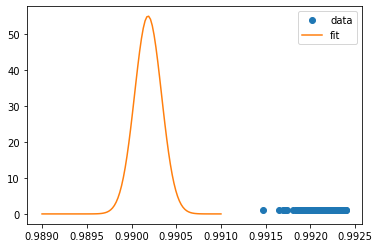

In [22]:
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(50,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()